# 05. Transfer learning in TensorFlow part 2: fine-tuning

In the previous notebook, we discovered transfer learning feature extraction, now it's time to learn about a new kind of transfer learning: fine-tuning

In [2]:
# Check gpu
!nvidia-smi

Fri Oct 25 10:16:16 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 555.42.06              Driver Version: 555.42.06      CUDA Version: 12.5     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 2060        Off |   00000000:01:00.0  On |                  N/A |
| 26%   54C    P0             36W /  170W |     500MiB /   6144MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

## 1. Creating helper functions

In previous notebooks, we've discovered bunch of helper functions, now we could rewrite them all however, this is tedious.

So it's a good idea to put functions you'll want to use again in a script you can download and import into your notebooks (or  wlsewhere).

We've done this for some of the functions we've used previousle here: https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/refs/heads/main/extras/helper_functions.py

In [4]:
!rm -rf helper_functions.py
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/refs/heads/main/extras/helper_functions.py

--2024-10-25 10:19:22--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/refs/heads/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2024-10-25 10:19:22 (38.8 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [5]:
# Import helper functions we're going to use i this notebook
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, walk_through_dir

> **Note:** If you're running this notebook in Google Colab, when it times out Colab will delete `helper_functions.py`, so you'll have to redownload it if you want access to your helper functions.

## 2. Let's get some data

This time we're going to see how we can use the pretrained models within `tf.keras.applications` and apply them to our own problem (recognizing images of food).

link: https://www.tensorflow.org/api_docs/python/tf/keras/applications

In [6]:
# Get 10% of training data of 10 classes of Food101
!rm -rf 10_food_classes_10_percent*
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

unzip_data("10_food_classes_10_percent.zip")
!rm -rf 10_food_classes_10_percent.zip

--2024-10-25 10:27:28--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 216.58.210.187, 216.58.211.251, 216.58.209.219, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|216.58.210.187|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M  35.1MB/s    in 5.5s    

2024-10-25 10:27:34 (29.3 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [7]:
# Check out how many images and subdirectories are inoour dataset
walk_through_dir("10_food_classes_10_percent")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/train'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_wings'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_curry'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ramen'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/steak'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/pizza'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/grilled_salmon'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/fried_rice'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ice_cream'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/hamburger'.
There are 0 directories and 75 images in '10_food_classes_10_percent

In [12]:
# Create training and test direcotry paths
train_dir = "10_food_classes_10_percent/train"
test_dir = "10_food_classes_10_percent/test"

IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32

In [13]:
import tensorflow as tf

In [15]:
train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    image_size=IMAGE_SIZE,
    label_mode="categorical",
    batch_size=BATCH_SIZE
)
test_data = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    image_size=IMAGE_SIZE,
    label_mode="categorical",
    batch_size=BATCH_SIZE
)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [16]:
# Check out the class names
train_data_10_percent.class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

## 3. Creating model using Functional API

The sequential API is straight-foward, it runs our layers in sequential order.

But the functional API gives us more flexibility with our models - https://www.tensorflow.org/guide/keras/functional_api

In [22]:
# 1. Create base model using tf.keras.applications
base_model = tf.keras.applications.efficientnet_v2.EfficientNetV2B0(include_top=False)

# 2. Freeze the base model (so the underlying pre-trained patterns aren't updated during training)
base_model.trainable = False

# 3. Create inputs into our model
inputs = tf.keras.layers.Input(
    shape = IMAGE_SIZE+(3,),
    name  = "input_layer"
)

# 4. If using ResNet50V2 you will need to normalize inputs
# x = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)(inputs)

# 5. Pass the inputs to the base_model
x = base_model(inputs)
print(f"Shape after passing inputs through base model: {x.shape}")

# 6. Average pool the outputs of the base model (aggregate all the mose important information, reduce number of computations)
x = tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
print(f"Shape after global average pooling: {x.shape}")

# 7. Create the output activation layer
outputs = tf.keras.layers.Dense(10, activation="softmax", name="output_layer")(x)

# 8. Combine the inputs with the outputs into a model
model_0 = tf.keras.Model(inputs, outputs)

# 9. Compile the model
model_0.compile(
    loss="categorical_crossentropy",
    optimizer=tf.keras.optimizers.Adam(),
    metrics=["accuracy"]
)

# 10. Fit the model and save its history
model_0_his = model_0.fit(
    train_data_10_percent,
    epochs=5,
    steps_per_epoch=len(train_data_10_percent),
    validation_data=test_data,
    validation_steps=int(0.25 * len(test_data)),
    callbacks=[create_tensorboard_callback(
        "transfer_learning",
        "10_percent_feature_extraction"
    )]
)

24274472/24274472 [==============================] - 1s 0us/step
Shape after passing inputs through base model: (None, 7, 7, 1280)
Shape after global average pooling: (None, 1280)
Saving TensorBoard log files to: transfer_learning/10_percent_feature_extraction/20241025-105923
Epoch 1/5
24/24 [==============================] - 11s 144ms/step - loss: 1.9576 - accuracy: 0.3800 - val_loss: 1.4021 - val_accuracy: 0.6875
Epoch 2/5
24/24 [==============================] - 2s 74ms/step - loss: 1.1874 - accuracy: 0.7347 - val_loss: 0.9503 - val_accuracy: 0.7977
Epoch 3/5
24/24 [==============================] - 2s 74ms/step - loss: 0.8612 - accuracy: 0.8067 - val_loss: 0.7738 - val_accuracy: 0.8339
Epoch 4/5
24/24 [==============================] - 2s 74ms/step - loss: 0.7062 - accuracy: 0.8413 - val_loss: 0.6879 - val_accuracy: 0.8306
Epoch 5/5
24/24 [==============================] - 2s 74ms/step - loss: 0.5981 - accuracy: 0.8640 - val_loss: 0.6131 - val_accuracy: 0.8421


In [23]:
# Evaluate on the full test dataset
model_0.evaluate(test_data)

79/79 [==============================] - 4s 45ms/step - loss: 0.5787 - accuracy: 0.8576


[0.5787246227264404, 0.8575999736785889]

In [28]:
# Check the layers in out base model
# for layer_number, layer in enumerate(base_model.layers):
#     print(f"{layer_number} {layer.name}")

In [29]:
# Let's get summary of the base model
# base_model.summary()

In [30]:
# How about a summary of our whole model
model_0.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetv2-b0 (Functio  (None, None, None, 1280   5919312   
 nal)                        )                                   
                                                                 
 global_average_pooling_lay  (None, 1280)              0         
 er (GlobalAveragePooling2D                                      
 )                                                               
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 5932122 (22.63 MB)
Trainable params: 12810 (50.04 KB)
Non-trainable params: 5919312 (22.58 MB)
__________________

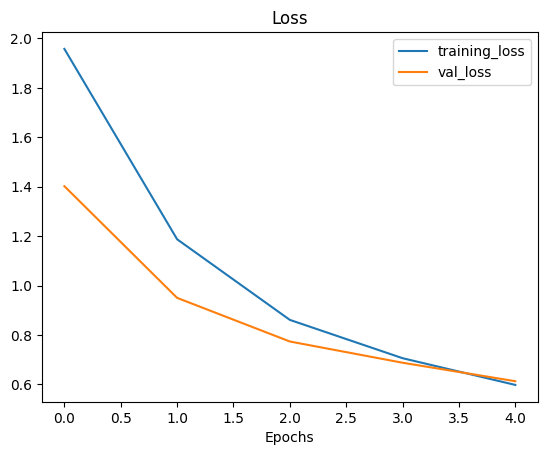

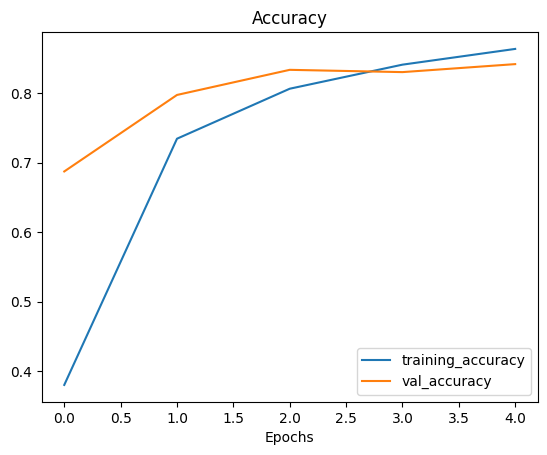

In [31]:
# Check out our model's training curves
plot_loss_curves(model_0_his)

## 4. Getting feature vector from a trained model

Let's demonstrate the Global Avergae Pooling 2D layer

We have a tensor after our model goes through `base_model` of shape (None, 7, 7, 1280).

But then when it passes through GlobalAveragePooling2D, it turns into (None, 1280).

Let's use a similar shaped tesnor of (1, 4, 4, 3) and then pass it to GlobalAveragePooling2D.

In [36]:
# Define the input shape
input_shape = (1, 4, 4, 3)

# Create random tensor
tf.random.set_seed(42)
input_tensor = tf.random.normal(input_shape)
print(f"Random tensor: {input_tensor}")

# Pass the random tensor through GlobalAveragePooling2D layer
global_average_pooled_tensor = tf.keras.layers.GlobalAveragePooling2D()(input_tensor)
print(f"2D global average pooled random tensor: {global_average_pooled_tensor}")

print(f"Shape of input tensor: {input_tensor.shape}\nShape of global avera tensor: {global_average_pooled_tensor.shape}")

Random tensor: [[[[ 0.3274685  -0.8426258   0.3194337 ]
   [-1.4075519  -2.3880599  -1.0392479 ]
   [-0.5573232   0.539707    1.6994323 ]
   [ 0.28893656 -1.5066116  -0.2645474 ]]

  [[-0.59722406 -1.9171132  -0.62044144]
   [ 0.8504023  -0.40604794 -3.0258412 ]
   [ 0.9058464   0.29855987 -0.22561555]
   [-0.7616443  -1.8917141  -0.93847126]]

  [[ 0.77852213 -0.47338894  0.97772694]
   [ 0.24694404  0.20573746 -0.52562326]
   [ 0.32410017  0.02545409 -0.10638496]
   [-0.63694745  1.1603122   0.2507359 ]]

  [[-0.41728503  0.4012578  -1.4145443 ]
   [-0.5931857  -1.6617213   0.33567193]
   [ 0.10815628  0.23479679 -0.56668764]
   [-0.35819843  0.88698614  0.52744764]]]]
2D global average pooled random tensor: [[-0.09368646 -0.45840448 -0.2885598 ]]
Shape of input tensor: (1, 4, 4, 3)
Shape of global avera tensor: (1, 3)


In [37]:
# Let's replicate the GlobalAveragePooling2D layer
tf.reduce_mean(input_tensor, axis=[1,2])

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[-0.09368646, -0.45840448, -0.2885598 ]], dtype=float32)>

## 5. Running a series of transfer learning experiments

We've seen the incredible results transfer learning can get with only 10% of the training data, but how does it go with 1% of the training data... how about we set up a bunch of experiments to find out:

1. `model_1` - use feature extraction transfer learning with 1% of the training data with data augmentation.
2. `model_2` - use feature extraction transfer learning with 10% of training data with data augmentation.
3. `model_3` - use fine-tuning transfer learning on 10% of the training data with data augmmentation.
4. `model_4` - use fine-tuning transfer learning on 100% of the training data with data augmentation.

> **Note:** throughout all experiments the same test dataset will be used to evaluate our model... this ensures consistency across evaluation metrics.

### 5.1 Setup data

In [39]:
# Download and unzip data
!rm -rf 10_food_classes_1_percent*
!rm -rf 10_food_classes_10_percent*
!rm -rf 10_food_classes_all_data*

!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip

unzip_data("10_food_classes_1_percent.zip")
unzip_data("10_food_classes_10_percent.zip")
unzip_data("10_food_classes_all_data.zip")

!rm -rf 10_food_classes_1_percent.zip
!rm -rf 10_food_classes_10_percent.zip
!rm -rf 10_food_classes_all_data.zip
!rm -rf __MACOSX*

--2024-10-25 11:29:08--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 216.58.209.219, 216.58.210.187, 216.58.211.251, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|216.58.209.219|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 133612354 (127M) [application/zip]
Saving to: ‘10_food_classes_1_percent.zip’

10_food_classes_1_p 100%[===================>] 127.42M  34.6MB/s    in 4.6s    

2024-10-25 11:29:13 (27.9 MB/s) - ‘10_food_classes_1_percent.zip’ saved [133612354/133612354]

--2024-10-25 11:29:14--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 216.58.209.219, 216.58.210.187, 216.58.211.251, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|216.58.209.219|:443... connected.
HTTP request sent, awaiting response... 200 OK


In [46]:
train_dir_1_percent = "10_food_classes_1_percent/train"
train_dir_10_percent = "10_food_classes_10_percent/train"
train_dir_all_data = "10_food_classes_all_data/train"
test_dir = "10_food_classes_all_data/test"

In [47]:
# Setup data loaders
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

train_data_1_percent = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir_1_percent,
    label_mode="categorical",
    batch_size=BATCH_SIZE,
    image_size=IMAGE_SIZE
)

train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir_10_percent,
    label_mode="categorical",
    batch_size=BATCH_SIZE,
    image_size=IMAGE_SIZE
)


train_data_all = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir_all_data,
    label_mode="categorical",
    batch_size=BATCH_SIZE,
    image_size=IMAGE_SIZE
)

test_data = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    label_mode="categorical",
    batch_size=BATCH_SIZE,
    image_size=IMAGE_SIZE
)

Found 70 files belonging to 10 classes.
Found 750 files belonging to 10 classes.
Found 7500 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [48]:
!rm -rf 10_food_classes_1_percent/
!rm -rf 10_food_classes_10_percent/
!rm -rf 10_food_classes_all_data/
!rm -rf transfer_learning/
!rm -rf helper_functions.py